In [1]:
from datetime import timedelta
from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

import json
import os

/home/kwanale1/anaconda3/envs/csc2552/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = json.loads(r.content)['data']['stations']
bikeshare_stations = pd.DataFrame(bikeshare_stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('./data/bikeshare_stations.csv', index=False)

In [3]:
bikeshare_stations.sample(10)

,station_id,name,lat,lon
109,7113.0,Parliament St / Aberdeen Ave,43.665278,-79.368333
433,7475.0,Jarvis St / Richmond St E,43.652777,-79.372637
39,7039.0,Simcoe St / Michael Sweet Ave,43.652327,-79.388254
28,7028.0,Gould St / Mutual St,43.658200,-79.376800
171,7180.0,Lansdowne Subway Station,43.658773,-79.443054
75,7076.0,York St / Queens Quay W,43.640132,-79.380464
411,7452.0,Bleecker St / St James Ave,43.669232,-79.374495
185,7197.0,Queen St W / Dovercourt Rd,43.643611,-79.422500
191,7205.0,Rusholme Park Cres / College St,43.652778,-79.429722
330,7361.0,Hocken Ave./Vaughan Rd.,43.681735,-79.418472


In [4]:
# Identify the date structure used by each of the files as a dict:
#      * Key: data file name
#      * Value: [datetime format, hour difference bewteen timezone used and Eastern timezone]

date_formats = {
    'Bike Share Toronto Ridership_Q1 2018.csv': ['%m/%d/%Y %H:%M', 0],
    'Bike Share Toronto Ridership_Q2 2018.csv': ['%m/%d/%Y %H:%M', 0],
    'Bike Share Toronto Ridership_Q3 2018.csv': ['%m/%d/%Y %H:%M', 0],
    'Bike Share Toronto Ridership_Q4 2018.csv': ['%m/%d/%Y %H:%M', 0],
}

df = pd.DataFrame() # Initiate an empty DataFrame
for fn, fmt in date_formats.items():
    tmp = pd.read_csv(os.path.join('./data', fn))
    tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce') # Read the datetime in the specified format
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=fmt[1])                       # Convert the input time to the Easter timezone

    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)                                    # Merge the content of the file to the main DataFrame

In [5]:
df.sample(10)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type
197265,2628059,277,7061,2018-04-07 22:28:00,Dalton Rd / Bloor St W,4/7/2018 22:33,7002,St. George St / Bloor St W,Annual Member
1197976,3755730,463,7037,2018-08-20 07:38:00,Bathurst St / Dundas St W,8/20/2018 7:46,7274,Queen's Park Cres E / Grosvenor St - SMART,Annual Member
1544927,4142504,998,7168,2018-09-28 16:41:00,Queens Quay / Yonge St,9/28/2018 16:57,7171,Ontario Place Blvd / Lakeshore Blvd W,Casual Member
231850,2669661,1715,7001,2018-04-21 15:28:00,Lower Jarvis St / The Esplanade,4/21/2018 15:56,7049,Queen St W / Portland St,Casual Member
1498106,4089973,1086,7171,2018-09-22 17:21:00,Ontario Place Blvd / Lakeshore Blvd W,9/22/2018 17:39,7226,Lakeshore Blvd W / The Boulevard Club,Casual Member
1669721,4282808,914,7049,2018-10-18 23:07:00,Queen St W / Portland St,10/18/2018 23:23,7139,Glen Edyth Dr / Davenport Rd,Annual Member
1805860,4442662,435,7049,2018-11-20 15:58:00,Queen St W / Portland St,11/20/2018 16:05,7176,Bathurst St / Fort York Blvd,Annual Member
294418,2742997,570,7078,2018-05-04 15:49:00,College St / Major St,5/4/2018 15:59,7209,Ossington Ave / Harrison St,Annual Member
163883,2587370,774,7252,2018-03-26 15:59:00,Robert St / Bloor St W - SMART,3/26/2018 16:12,7180,Lansdowne Subway Station,Annual Member
1191508,3748668,544,7000,2018-08-19 13:56:00,Fort York Blvd / Capreol Ct,8/19/2018 14:05,7016,Bay St / Queens Quay W (Ferry Terminal),Annual Member


In [6]:
stations_start = df[['from_station_id', 'from_station_name']]
stations_end = df[['to_station_id', 'to_station_name']]
stations_start.columns = stations_end.columns = ['station_id', 'name']

# Extracts the unique station ID and name combination from the from_station and to_station columns
stations = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

In [7]:
stations.sample(10)

,station_id,name
240,7157,Dufferin St / Bloor St
314,7345,Cherry Beach Sports Field (55 Unwin Ave)
153,7036,Trinity St /Front St E
298,7326,Davenport Rd / Lansdowne Ave.
195,7070,25 York St  Union Station South
73,7039,Simcoe St / Michael Sweet Ave
242,7188,Exhibition GO (Atlantic Ave)
128,7281,Charles St W / Balmuto St - SMART
19,7103,Jimmie Simpson Park (Queen St E)
55,7267,Dundas St E / Pembroke St - SMART


In [8]:
# Separate the stations without station IDs
no_ids = stations[stations['station_id'].isnull()]
for idx, miss in no_ids.iterrows():
    max_score = 0
    
    # Compare the similarity of the station without ID to each station in the API data
    for i, exist in bikeshare_stations[['station_id', 'name']].iterrows():
        score = fuzz.ratio(miss['name'], exist['name'])
        
        if score > 80 and score > max_score:
            max_score = score
            no_ids.at[idx, 'station_id'] = exist['station_id']
    
    # Warn if the station was not able to be matched
    if max_score <= 80:
        print('WARN: {0} station could not be matched to an existing station'.format(miss['name']))

# Remove all stations that were not matched
no_ids = no_ids.dropna()

In [9]:
stations = pd.concat([stations[~stations['station_id'].isnull()], no_ids])\
             .merge(bikeshare_stations[['station_id', 'lat', 'lon']], how='inner', on='station_id')\
             .drop_duplicates()

In [10]:
df = df.merge(stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()

df = df[[x for x in df.columns if not x.endswith('_station_id') and not x.endswith('_station_name') and x != 'trip_stop_time']]

In [11]:
df.sample(10)

,trip_id,trip_duration_seconds,trip_start_time,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to
575329,4507066,140,2018-12-07 09:03:00,Annual Member,7257,Dundas St W / St. Patrick St,43.654517,-79.389532,7022,Simcoe St / Queen St W,43.650858,-79.387582
728721,3708451,1224,2018-08-15 11:12:00,Casual Member,7063,Queen's Park / Bloor St W,43.668456,-79.393899,7142,Bridgeman Ave / Bathurst St,43.674444,-79.414722
1079618,3819562,532,2018-08-26 19:06:00,Annual Member,7299,Mill St / Parliament St,43.650256,-79.361630,7019,Temperance St. Station,43.650702,-79.380055
756321,2659495,175,2018-04-19 09:44:00,Annual Member,7035,Queen St W / Ossington Ave,43.643975,-79.419576,7111,King St W / Douro St,43.640885,-79.416379
1094212,2813941,430,2018-05-14 15:45:00,Annual Member,7066,Willcocks St / St. George St,43.662085,-79.397735,7020,Phoebe St / Spadina Ave,43.650033,-79.396555
317358,4527025,1271,2018-12-12 17:30:00,Annual Member,7158,King St W / Stafford St,43.642222,-79.411111,7108,Front St E / Cherry St,43.652686,-79.358395
1722708,3182961,690,2018-06-24 20:56:00,Annual Member,7096,Boston Ave / Queen St E,43.661508,-79.338931,7309,Queen St. E / Rhodes Ave.,43.666224,-79.317693
882183,2399481,739,2018-01-12 16:06:00,Annual Member,7077,College Park South,43.659777,-79.382767,7023,College St / Borden St,43.657100,-79.405600
765834,3281678,177,2018-07-04 22:04:00,Annual Member,7203,Bathurst St/Queens Quay(Billy Bishop Airport),43.635492,-79.398253,7075,Queens Quay W / Dan Leckie Way,43.636533,-79.395854
81922,3989849,209,2018-09-13 09:07:00,Annual Member,7004,University Ave / Elm St,43.656518,-79.389099,7041,Edward St / Yonge St,43.656729,-79.382736


In [12]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06
mean,3.491517e+06,9.600563e+02,7.134791e+03,4.365380e+01,-7.939173e+01,7.134587e+03,4.365298e+01,-7.939122e+01
std,6.256583e+05,1.592725e+03,1.036597e+02,1.140237e-02,2.389161e-02,1.038051e+02,1.104151e-02,2.416744e-02
min,2.383648e+06,6.000000e+01,7.000000e+03,4.362244e+01,-7.948028e+01,7.000000e+03,4.362244e+01,-7.948028e+01
25%,2.954888e+06,4.220000e+02,7.042000e+03,4.364561e+01,-7.940185e+01,7.042000e+03,4.364534e+01,-7.940150e+01
50%,3.495005e+06,6.690000e+02,7.111000e+03,4.365282e+01,-7.938886e+01,7.109000e+03,4.365212e+01,-7.938780e+01
75%,4.029936e+06,1.048000e+03,7.224000e+03,4.366222e+01,-7.938004e+01,7.224000e+03,4.366056e+01,-7.937988e+01
max,4.581277e+06,5.507700e+04,7.391000e+03,4.371122e+01,-7.928145e+01,7.391000e+03,4.371122e+01,-7.928145e+01


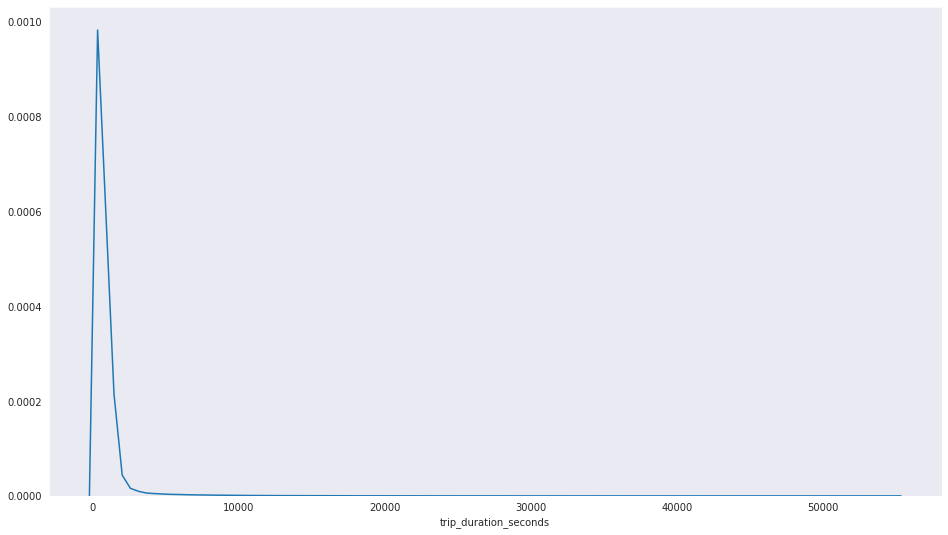

In [13]:
sns.set_style('dark')

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.distplot(df['trip_duration_seconds'], hist=False, ax=ax)

plt.savefig('./visualization/raw_distributions.png')

In [14]:
df.shape

(1893605, 12)

In [15]:
df = df[(df['trip_duration_seconds']>=60)]

In [16]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06,1.893605e+06
mean,3.491517e+06,9.600563e+02,7.134791e+03,4.365380e+01,-7.939173e+01,7.134587e+03,4.365298e+01,-7.939122e+01
std,6.256583e+05,1.592725e+03,1.036597e+02,1.140237e-02,2.389161e-02,1.038051e+02,1.104151e-02,2.416744e-02
min,2.383648e+06,6.000000e+01,7.000000e+03,4.362244e+01,-7.948028e+01,7.000000e+03,4.362244e+01,-7.948028e+01
25%,2.954888e+06,4.220000e+02,7.042000e+03,4.364561e+01,-7.940185e+01,7.042000e+03,4.364534e+01,-7.940150e+01
50%,3.495005e+06,6.690000e+02,7.111000e+03,4.365282e+01,-7.938886e+01,7.109000e+03,4.365212e+01,-7.938780e+01
75%,4.029936e+06,1.048000e+03,7.224000e+03,4.366222e+01,-7.938004e+01,7.224000e+03,4.366056e+01,-7.937988e+01
max,4.581277e+06,5.507700e+04,7.391000e+03,4.371122e+01,-7.928145e+01,7.391000e+03,4.371122e+01,-7.928145e+01


In [17]:
df.shape

(1893605, 12)

In [18]:
q1 = df['trip_duration_seconds'].quantile(0.25)
q3 = df['trip_duration_seconds'].quantile(0.75)
interquartile_range = q3 - q1

df = df[~((df['trip_duration_seconds'] < (q1 - 1.5 * interquartile_range))|(df['trip_duration_seconds'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)

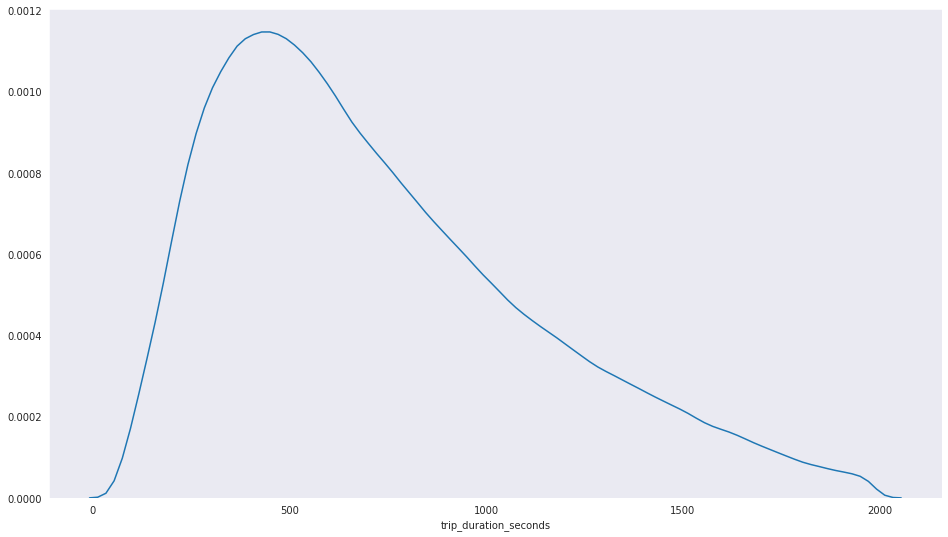

In [19]:
sns.set_style('dark')

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.distplot(df['trip_duration_seconds'], hist=False, ax=ax)

plt.savefig('./visualization/raw_distributions_1.png')

In [20]:
df.shape

(1798834, 12)

In [21]:
df.to_csv('./data/bikeshare_ridership.csv', index=False)